In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os   # zip file from drive and setup,
import shutil
import zipfile

# Source and destination paths
source_zip = "/content/drive/MyDrive/FER465/augmented-data/fer-2013-all.zip"
destination_dir = "/content/FER-2013"

def setup_directory(directory_path):
    """Create directory if it doesn't exist, clear it if it does."""
    # Check if directory exists
    if os.path.exists(directory_path):
        print(f"Directory {directory_path} exists. Clearing contents...")
        # Remove all contents
        for item in os.listdir(directory_path):
            item_path = os.path.join(directory_path, item)
            if os.path.isfile(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        print(f"Directory {directory_path} cleared.")
    else:
        # Create directory and any necessary parent directories
        print(f"Creating directory {directory_path}...")
        os.makedirs(directory_path, exist_ok=True)
        print(f"Directory {directory_path} created.")

def extract_zip(zip_path, extract_to):
    """Extract contents of zip file to specified directory."""
    print(f"Extracting {zip_path} to {extract_to}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete.")

if __name__ == "__main__":
    # Make sure parent directories exist
    os.makedirs(os.path.dirname(destination_dir), exist_ok=True)

    # Setup the destination directory
    setup_directory(destination_dir)

    # Extract the ZIP file
    if os.path.exists(source_zip):
        extract_zip(source_zip, destination_dir)
        print(f"Successfully extracted {source_zip} to {destination_dir}")
    else:
        print(f"Error: Source file {source_zip} not found.")

Creating directory /content/FER-2013...
Directory /content/FER-2013 created.
Extracting /content/drive/MyDrive/FER465/augmented-data/fer-2013-all.zip to /content/FER-2013...
Extraction complete.
Successfully extracted /content/drive/MyDrive/FER465/augmented-data/fer-2013-all.zip to /content/FER-2013


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from PIL import Image
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random

In [6]:
# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define constants
DATA_DIR = '/content/FER-2013/all'
MODEL_SAVE_DIR = '/content/drive/MyDrive/FER465/models'
NUM_EPOCHS = 70  # Increased to 70 epochs for single train
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 1e-4
NUM_CLASSES = 7  # 7 emotions in FER-2013
VALIDATION_SPLIT = 0.2  # 80% train, 20% validation

# Create model directory if it doesn't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"Models will be saved to: {MODEL_SAVE_DIR}")

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define enhanced image transformations with more augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize larger than needed
    transforms.RandomCrop(224),     # Random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Models will be saved to: /content/drive/MyDrive/FER465/models
Using device: cuda


In [7]:
# Custom dataset class for FER-2013
class FERDataset(Dataset):
    def __init__(self, data_dir, transform=None, subset=None):
        self.data_dir = data_dir
        self.transform = transform

        # Get emotion classes from train directory
        train_dir = os.path.join(data_dir, 'train')
        self.classes = sorted([d for d in os.listdir(train_dir)
                              if os.path.isdir(os.path.join(train_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.samples = []
        self.targets = []  # Store targets separately for stratified sampling

        # If subset is specified (train or test), only use that folder
        # Otherwise, use both train and test for cross-validation
        subsets = [subset] if subset else ['train', 'test']

        for subset_name in subsets:
            subset_dir = os.path.join(data_dir, subset_name)
            if not os.path.isdir(subset_dir):
                continue

            for class_name in self.classes:
                class_dir = os.path.join(subset_dir, class_name)
                if os.path.isdir(class_dir):
                    for img_name in os.listdir(class_dir):
                        img_path = os.path.join(class_dir, img_name)
                        if os.path.isfile(img_path):  # Make sure it's a file, not a directory
                            label = self.class_to_idx[class_name]
                            self.samples.append((img_path, label))
                            self.targets.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Handle grayscale images and potential errors
        try:
            image = Image.open(img_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
        except (IOError, OSError) as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image and the label if there's an error
            image = Image.new('RGB', (224, 224), color=0)

        if self.transform:
            image = self.transform(image)

        return image, label

# Custom ResBlock for our model
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

class AttentionEmotionNet(nn.Module):
    def __init__(self, num_classes=7):
        super(AttentionEmotionNet, self).__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Apply attention
        attn = self.attention(x)
        x = x * attn

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [8]:
# Function to train one epoch with progress tracking
def train_epoch(model, train_loader, criterion, optimizer, epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    batch_count = len(train_loader)

    start_time = time.time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print progress
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == batch_count:
            elapsed_time = time.time() - start_time
            print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{batch_idx+1}/{batch_count}] | "
                  f"Loss: {loss.item():.4f} | Acc: {100.*correct/total:.2f}% | "
                  f"Time: {elapsed_time:.2f}s")

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Function to evaluate model
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    class_correct = [0] * NUM_CLASSES
    class_total = [0] * NUM_CLASSES

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Per-class accuracy
            for i in range(len(labels)):
                label = labels[i]
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1

            # Store predictions and labels for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate class accuracies
    class_accuracies = [class_correct[i] / max(1, class_total[i]) for i in range(NUM_CLASSES)]

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels, class_accuracies

# Create a FocalLoss class for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

Loading dataset...
Dataset loaded with 46648 samples
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Class distribution:
  angry: 6438 samples (13.80%)
  disgust: 710 samples (1.52%)
  fear: 6657 samples (14.27%)
  happy: 11685 samples (25.05%)
  neutral: 8056 samples (17.27%)
  sad: 7900 samples (16.94%)
  surprise: 5202 samples (11.15%)

Training samples: 37318, Validation samples: 9330


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Trainable parameters: 11,180,616 (100.00% of total)

Training epoch 1/70...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Epoch [4/70] | Batch [470/584] | Loss: 0.9192 | Acc: 41.47% | Time: 123.37s
Epoch [4/70] | Batch [480/584] | Loss: 0.8793 | Acc: 41.53% | Time: 125.65s
Epoch [4/70] | Batch [490/584] | Loss: 1.0610 | Acc: 41.61% | Time: 127.87s
Epoch [4/70] | Batch [500/584] | Loss: 0.9562 | Acc: 41.71% | Time: 130.27s
Epoch [4/70] | Batch [510/584] | Loss: 0.9400 | Acc: 41.74% | Time: 133.90s
Epoch [4/70] | Batch [520/584] | Loss: 0.9248 | Acc: 41.77% | Time: 136.57s
Epoch [4/70] | Batch [530/584] | Loss: 0.8801 | Acc: 41.78% | Time: 138.81s
Epoch [4/70] | Batch [540/584] | Loss: 0.6889 | Acc: 41.85% | Time: 141.18s
Epoch [4/70] | Batch [550/584] | Loss: 1.1239 | Acc: 41.88% | Time: 143.36s
Epoch [4/70] | Batch [560/584] | Loss: 1.0107 | Acc: 41.93% | Time: 147.01s
Epoch [4/70] | Batch [570/584] | Loss: 0.9737 | Acc: 41.95% | Time: 149.61s
Epoch [4/70] | Batch [580/584] | Loss: 1.0229 | Acc: 41.93% | Time: 151.92s
Epoch [4/70] | Batch [584/584] | Loss

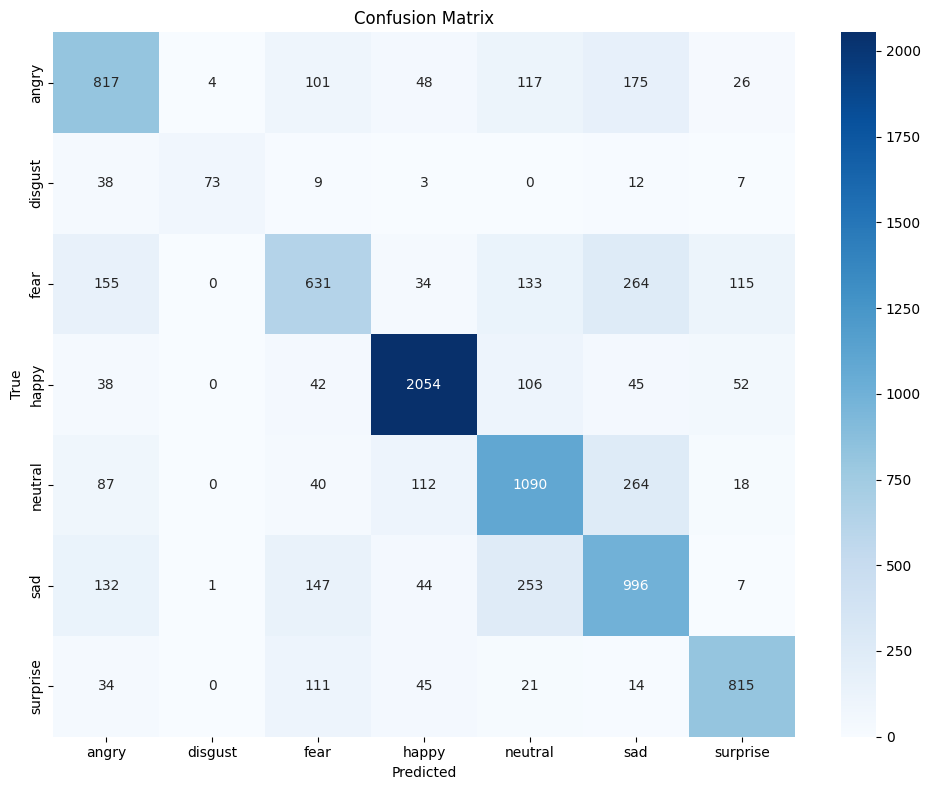

Saved final model to /content/drive/MyDrive/FER465/models/resemotenet_final.pt


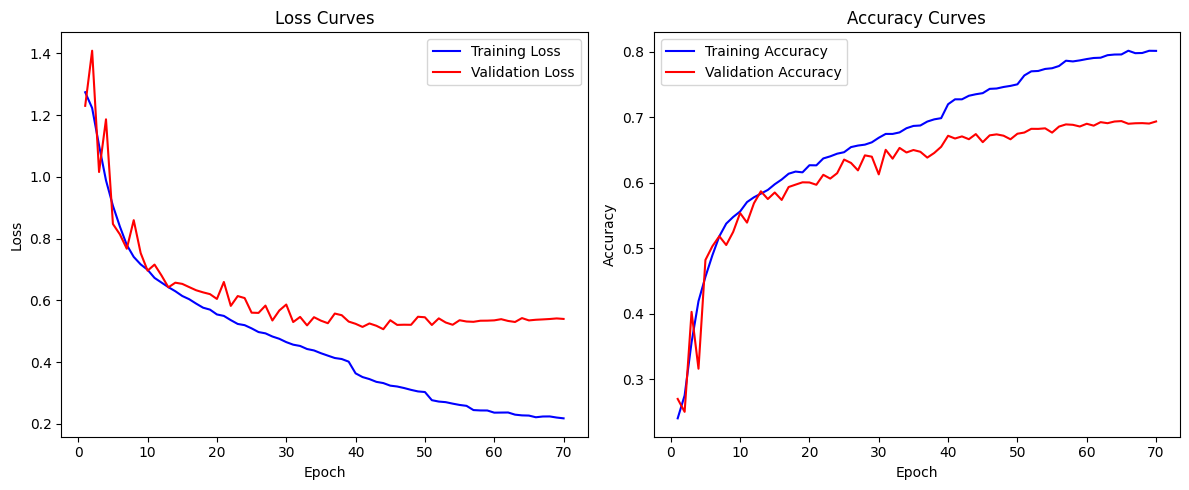


Training completed! A comprehensive report has been saved to '/content/drive/MyDrive/FER465/models/resemotenet_report.txt'
Training curves saved to '/content/drive/MyDrive/FER465/models/training_curves.png'


In [11]:
# Main training function
def train_emotion_model():
    print("Loading dataset...")
    # Load the dataset
    dataset = FERDataset(DATA_DIR, transform=None)  # No transform here, we'll apply it dynamically
    print(f"Dataset loaded with {len(dataset)} samples")
    print(f"Classes: {dataset.classes}")

    # Get class distribution for balancing
    class_counts = [0] * NUM_CLASSES
    for _, label in dataset.samples:
        class_counts[label] += 1

    total_samples = len(dataset)
    print(f"Class distribution:")
    for i, count in enumerate(class_counts):
        print(f"  {dataset.classes[i]}: {count} samples ({count/total_samples*100:.2f}%)")

    # Create train/validation split using stratified sampling
    indices = list(range(len(dataset)))
    train_idx, val_idx = train_test_split(
        indices,
        test_size=VALIDATION_SPLIT,
        random_state=42,
        stratify=dataset.targets
    )

    print(f"\nTraining samples: {len(train_idx)}, Validation samples: {len(val_idx)}")

    # Create separate datasets for training and validation with appropriate transforms
    train_dataset = FERDataset(DATA_DIR, transform=train_transform, subset=None)
    val_dataset = FERDataset(DATA_DIR, transform=val_transform, subset=None)

    # Create samplers for the datasets
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        num_workers=4,  # Increase workers for faster data loading
        pin_memory=True  # Speed up data transfer to GPU
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        sampler=val_sampler,
        num_workers=4,
        pin_memory=True
    )

    # Create the model
    model = AttentionEmotionNet(num_classes=NUM_CLASSES).to(device)

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}% of total)")

    # Use Focal Loss to handle class imbalance
    criterion = FocalLoss(gamma=2.0)

    # Use AdamW optimizer with weight decay for better regularization
    optimizer = optim.AdamW(
        [
            {'params': [p for n, p in model.named_parameters() if 'fc' not in n], 'lr': LEARNING_RATE/10},
            {'params': model.fc.parameters(), 'lr': LEARNING_RATE}
        ],
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

    # Add learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training loop with enhanced monitoring
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    patience = 10  # Early stopping patience
    patience_counter = 0

    for epoch in range(NUM_EPOCHS):
        # Train
        print(f"\nTraining epoch {epoch+1}/{NUM_EPOCHS}...")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch, NUM_EPOCHS)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate
        print(f"\nEvaluating epoch {epoch+1}/{NUM_EPOCHS}...")
        val_loss, val_acc, val_preds, val_labels, class_accs = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Print per-class accuracies
        print("\nPer-class accuracies:")
        for i, acc in enumerate(class_accs):
            print(f"  {dataset.classes[i]}: {acc*100:.2f}%")

        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} Summary - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save model if it's the best so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = os.path.join(MODEL_SAVE_DIR, 'attentionemotionnet_best.pt')
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model with validation accuracy: {best_val_acc:.4f} to {model_path}")
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
            print(f"Validation accuracy didn't improve. Patience: {patience_counter}/{patience}")

        # Early stopping check
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Final evaluation using the best model
    print("\nLoading best model for final evaluation...")
    model_path = os.path.join(MODEL_SAVE_DIR, 'attentionemotionnet_best.pt')
    model.load_state_dict(torch.load(model_path))

    final_val_loss, final_val_acc, val_preds, val_labels, class_accs = evaluate(model, val_loader, criterion)

    # Calculate classification report and confusion matrix
    class_names = dataset.classes
    report = classification_report(val_labels, val_preds, target_names=class_names)
    conf_matrix = confusion_matrix(val_labels, val_preds)

    print("\nFinal Evaluation using best model:")
    print(f"Validation accuracy: {final_val_acc:.4f}")

    print("\nClassification Report:")
    print(report)

    print("\nConfusion Matrix:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Save final model
    final_model_path = os.path.join(MODEL_SAVE_DIR, 'attentionemotionnet_final.pt')
    torch.save(model.state_dict(), final_model_path)
    print(f"Saved final model to {final_model_path}")

    # Plot training and validation curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accs)+1), train_accs, 'b-', label='Training Accuracy')
    plt.plot(range(1, len(val_accs)+1), val_accs, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_DIR, 'training_curves.png'))
    plt.show()

    # Save a comprehensive report
    report_path = os.path.join(MODEL_SAVE_DIR, 'attentionemotionnet_report.txt')
    with open(report_path, 'w') as f:
        f.write("FER Classification with AttentionEmotionNet - Training Report\n")
        f.write("="*50 + "\n\n")
        f.write(f"Best Validation Accuracy: {best_val_acc:.4f}\n")
        f.write(f"Final Validation Accuracy: {final_val_acc:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report + "\n\n")
        f.write("Per-class accuracies:\n")
        for i, acc in enumerate(class_accs):
            f.write(f"  {dataset.classes[i]}: {acc*100:.2f}%\n")

    print(f"\nTraining completed! A comprehensive report has been saved to '{report_path}'")
    print(f"Training curves saved to '{os.path.join(MODEL_SAVE_DIR, 'training_curves.png')}'")

if __name__ == "__main__":
    import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from PIL import Image
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define constants
DATA_DIR = '/content/FER-2013/all'
MODEL_SAVE_DIR = '/content/drive/MyDrive/FER465/models'
NUM_EPOCHS = 70  # Increased to 70 epochs for single train
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 1e-4
NUM_CLASSES = 7  # 7 emotions in FER-2013
VALIDATION_SPLIT = 0.2  # 80% train, 20% validation

# Create model directory if it doesn't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"Models will be saved to: {MODEL_SAVE_DIR}")

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define enhanced image transformations with more augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize larger than needed
    transforms.RandomCrop(224),     # Random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom dataset class for FER-2013
class FERDataset(Dataset):
    def __init__(self, data_dir, transform=None, subset=None):
        self.data_dir = data_dir
        self.transform = transform

        # Get emotion classes from train directory
        train_dir = os.path.join(data_dir, 'train')
        self.classes = sorted([d for d in os.listdir(train_dir)
                              if os.path.isdir(os.path.join(train_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.samples = []
        self.targets = []  # Store targets separately for stratified sampling

        # If subset is specified (train or test), only use that folder
        # Otherwise, use both train and test for cross-validation
        subsets = [subset] if subset else ['train', 'test']

        for subset_name in subsets:
            subset_dir = os.path.join(data_dir, subset_name)
            if not os.path.isdir(subset_dir):
                continue

            for class_name in self.classes:
                class_dir = os.path.join(subset_dir, class_name)
                if os.path.isdir(class_dir):
                    for img_name in os.listdir(class_dir):
                        img_path = os.path.join(class_dir, img_name)
                        if os.path.isfile(img_path):  # Make sure it's a file, not a directory
                            label = self.class_to_idx[class_name]
                            self.samples.append((img_path, label))
                            self.targets.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Handle grayscale images and potential errors
        try:
            image = Image.open(img_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
        except (IOError, OSError) as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image and the label if there's an error
            image = Image.new('RGB', (224, 224), color=0)

        if self.transform:
            image = self.transform(image)

        return image, label

# Custom ResBlock for our model
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

# AttentionEmotionNet model definition - a custom architecture for emotion recognition with attention
class AttentionEmotionNet(nn.Module):
    def __init__(self, num_classes=7):
        super(AttentionEmotionNet, self).__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Apply attention
        attn = self.attention(x)
        x = x * attn

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

# Function to train one epoch with progress tracking
def train_epoch(model, train_loader, criterion, optimizer, epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    batch_count = len(train_loader)

    start_time = time.time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print progress
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == batch_count:
            elapsed_time = time.time() - start_time
            print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{batch_idx+1}/{batch_count}] | "
                  f"Loss: {loss.item():.4f} | Acc: {100.*correct/total:.2f}% | "
                  f"Time: {elapsed_time:.2f}s")

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Function to evaluate model
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    class_correct = [0] * NUM_CLASSES
    class_total = [0] * NUM_CLASSES

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Per-class accuracy
            for i in range(len(labels)):
                label = labels[i]
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1

            # Store predictions and labels for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate class accuracies
    class_accuracies = [class_correct[i] / max(1, class_total[i]) for i in range(NUM_CLASSES)]

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels, class_accuracies

# Create a FocalLoss class for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Main training function
def train_emotion_model():
    print("Loading dataset...")
    # Load the dataset
    dataset = FERDataset(DATA_DIR, transform=None)  # No transform here, we'll apply it dynamically
    print(f"Dataset loaded with {len(dataset)} samples")
    print(f"Classes: {dataset.classes}")

    # Get class distribution for balancing
    class_counts = [0] * NUM_CLASSES
    for _, label in dataset.samples:
        class_counts[label] += 1

    total_samples = len(dataset)
    print(f"Class distribution:")
    for i, count in enumerate(class_counts):
        print(f"  {dataset.classes[i]}: {count} samples ({count/total_samples*100:.2f}%)")

    # Create train/validation split using stratified sampling
    indices = list(range(len(dataset)))
    train_idx, val_idx = train_test_split(
        indices,
        test_size=VALIDATION_SPLIT,
        random_state=42,
        stratify=dataset.targets
    )

    print(f"\nTraining samples: {len(train_idx)}, Validation samples: {len(val_idx)}")

    # Create separate datasets for training and validation with appropriate transforms
    train_dataset = FERDataset(DATA_DIR, transform=train_transform, subset=None)
    val_dataset = FERDataset(DATA_DIR, transform=val_transform, subset=None)

    # Create samplers for the datasets
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        num_workers=4,  # Increase workers for faster data loading
        pin_memory=True  # Speed up data transfer to GPU
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        sampler=val_sampler,
        num_workers=4,
        pin_memory=True
    )

    # Create the model
    model = AttentionEmotionNet(num_classes=NUM_CLASSES).to(device)

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}% of total)")

    # Use Focal Loss to handle class imbalance
    criterion = FocalLoss(gamma=2.0)

    # Use AdamW optimizer with weight decay for better regularization
    optimizer = optim.AdamW(
        [
            {'params': [p for n, p in model.named_parameters() if 'fc' not in n], 'lr': LEARNING_RATE/10},
            {'params': model.fc.parameters(), 'lr': LEARNING_RATE}
        ],
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

    # Add learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training loop with enhanced monitoring
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    patience = 10  # Early stopping patience
    patience_counter = 0

    for epoch in range(NUM_EPOCHS):
        # Train
        print(f"\nTraining epoch {epoch+1}/{NUM_EPOCHS}...")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch, NUM_EPOCHS)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate
        print(f"\nEvaluating epoch {epoch+1}/{NUM_EPOCHS}...")
        val_loss, val_acc, val_preds, val_labels, class_accs = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Print per-class accuracies
        print("\nPer-class accuracies:")
        for i, acc in enumerate(class_accs):
            print(f"  {dataset.classes[i]}: {acc*100:.2f}%")

        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} Summary - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save model if it's the best so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = os.path.join(MODEL_SAVE_DIR, 'attentionemotionnet_best.pt')
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model with validation accuracy: {best_val_acc:.4f} to {model_path}")
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
            print(f"Validation accuracy didn't improve. Patience: {patience_counter}/{patience}")

        # Early stopping check
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Final evaluation using the best model
    print("\nLoading best model for final evaluation...")
    model_path = os.path.join(MODEL_SAVE_DIR, 'attentionemotionnet_best.pt')
    model.load_state_dict(torch.load(model_path))

    final_val_loss, final_val_acc, val_preds, val_labels, class_accs = evaluate(model, val_loader, criterion)

    # Calculate classification report and confusion matrix
    class_names = dataset.classes
    report = classification_report(val_labels, val_preds, target_names=class_names)
    conf_matrix = confusion_matrix(val_labels, val_preds)

    print("\nFinal Evaluation using best model:")
    print(f"Validation accuracy: {final_val_acc:.4f}")

    print("\nClassification Report:")
    print(report)

    print("\nConfusion Matrix:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Save final model
    final_model_path = os.path.join(MODEL_SAVE_DIR, 'attentionemotionnet_final.pt')
    torch.save(model.state_dict(), final_model_path)
    print(f"Saved final model to {final_model_path}")

    # Plot training and validation curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accs)+1), train_accs, 'b-', label='Training Accuracy')
    plt.plot(range(1, len(val_accs)+1), val_accs, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_DIR, 'training_curves.png'))
    plt.show()

    # Save a comprehensive report
    report_path = os.path.join(MODEL_SAVE_DIR, 'attentionemotionnet_report.txt')
    with open(report_path, 'w') as f:
        f.write("FER Classification with AttentionEmotionNet - Training Report\n")
        f.write("="*50 + "\n\n")
        f.write(f"Best Validation Accuracy: {best_val_acc:.4f}\n")
        f.write(f"Final Validation Accuracy: {final_val_acc:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report + "\n\n")
        f.write("Per-class accuracies:\n")
        for i, acc in enumerate(class_accs):
            f.write(f"  {dataset.classes[i]}: {acc*100:.2f}%\n")

    print(f"\nTraining completed! A comprehensive report has been saved to '{report_path}'")
    print(f"Training curves saved to '{os.path.join(MODEL_SAVE_DIR, 'training_curves.png')}'")

if __name__ == "__main__":
    train_emotion_model()